In [58]:
# I will use the tweets from the Kaggle competition website (https://www.kaggle.com/crowdflower/twitter-airline-sentiment)
# as my training set and will use the coronavirus csv as my test set
#importing pandas to be able to manipulate the tables
import pandas as pd

# reading in my two texts and importing nltk libraries
import nltk
from nltk import sent_tokenize

# loading the test set
test_set = pd.read_csv('test_covid.csv')

In [17]:
import csv
#using the Airline Services dataset for training on sentiment polarity
train_dataset = pd.read_csv('tweets.csv')
#displaying the dataset using pandas
display(len(train_dataset))
display(train_dataset.head(2))

14640

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [18]:
# removing the @ and # from the training data because its from twitter using regular expressions
def remove_at(x):
    x = str(x).replace('@', '')
    x = str(x).replace('#', '')
    return x

In [19]:
#applyting the clearning function and visualizing the result
train_dataset['text'] = train_dataset['text'].apply(lambda x: remove_at(x))
display(len(train_dataset))
display(train_dataset['text'].head(5))

14640

0                    VirginAmerica What dhepburn said.
1    VirginAmerica plus you've added commercials to...
2    VirginAmerica I didn't today... Must mean I ne...
3    VirginAmerica it's really aggressive to blast ...
4    VirginAmerica and it's a really big bad thing ...
Name: text, dtype: object

In [20]:
#tokenizing the training dataset using regular expressions as well
tokenizer = nltk.RegexpTokenizer('\w+')
doc = train_dataset['text'].apply(lambda x : tokenizer.tokenize(x))
display(len(doc))
display(doc.head(5))

14640

0                [VirginAmerica, What, dhepburn, said]
1    [VirginAmerica, plus, you, ve, added, commerci...
2    [VirginAmerica, I, didn, t, today, Must, mean,...
3    [VirginAmerica, it, s, really, aggressive, to,...
4    [VirginAmerica, and, it, s, a, really, big, ba...
Name: text, dtype: object

In [21]:
#performing exploratory analysis, seeing if the dataset is balanced and extracting labels from the sentiment column
PosSentences = train_dataset[train_dataset['airline_sentiment'] == 'positive']
NegSentences = train_dataset[train_dataset['airline_sentiment'] == 'negative']
NeuSentences = train_dataset[train_dataset['airline_sentiment'] == 'neutral']

#grouping all labels to find out the count for each group
label_groups = train_dataset.groupby('airline_sentiment').size().reset_index(name='counts')
display(label_groups.head(5))

,airline_sentiment,counts
0,negative,9178
1,neutral,3099
2,positive,2363


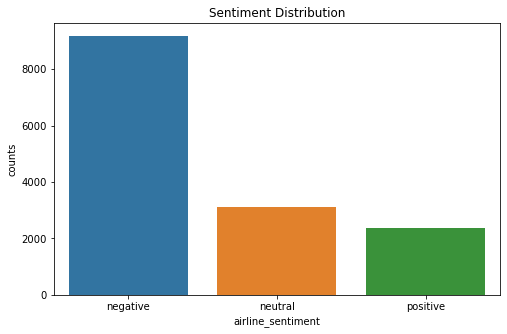

In [22]:
#Visualizing label group data within training dataset
# We can see that this dataset is unbalanced having many more negetice tweets so we will have to balance the data

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
ax = sns.barplot(x="airline_sentiment", y="counts", data=label_groups)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title(label="Sentiment Distribution")
plt.show()

In [53]:
# Imbalanced data can cause our model accuracy to be off, we can have very high accuracy by predicting the majority class
# but with this we fail to capture the minority class as well so we will be right most of the time by only predicting one class


In [35]:
# here we are extracting the tweet message and its asigned sentiment label
# we are creating a python list and extracting the tweet message and its asigned sentiment label

# opening a list to store our data
docs = []

# iterating over the dataset and extracting the information sought
for i in range(0, len(train_dataset['airline_sentiment'])):
    # appending the info to the list
    docs.append((doc[i], train_dataset['airline_sentiment'][i]))

#printing the output for validation
docs[0]

(['VirginAmerica', 'What', 'dhepburn', 'said'], 'neutral')

In [36]:
# Randomizing the dataset to avoid sampling bias because it is sorted by sentiment level
#importing the random library
import random

#shuffling the documents
random.shuffle(docs)

In [37]:
 #defining set of words that will be used for features
#we'll find the 2000 most common words and used them as an important feature of the whole corpus

all_words = [word for (sentance,category) in docs for word in sentance]
top_words = nltk.FreqDist(all_words)
most_common_words = top_words.most_common(2000)
word_features = [word for (word,count) in most_common_words]

In [38]:
#checking if we have the 2000 words we need
len(set(all_words))

18042

In [39]:
#using the list of most frequent words to go over each sentence and see if the words are present
#defining a function document_features
def document_features(document, word_features):
    document_words = set(document)
    #we open a Pytnon dictionary instead of a list
    features = {}
    for word in word_features:
        #checking if the word from word_features matches a word in the document
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [40]:
#applying the function to the document dataset
featuresets = [(document_features(d, word_features), c) for (d, c) in docs]

#we print the list of features matches for the first document ([0]) in the corpus
#we'll see a Python dictionary with the key being the feature word
#and the value being 'True' or 'False' according to that word being matched in the present document or not
#we'll se a lot of 'False' values because (of course) not all 2000 words will be on each sentence!
featuresets[0]

({'contains(to)': True,
  'contains(I)': True,
  'contains(the)': True,
  'contains(a)': False,
  'contains(for)': False,
  'contains(you)': True,
  'contains(united)': False,
  'contains(on)': False,
  'contains(and)': False,
  'contains(t)': False,
  'contains(flight)': False,
  'contains(my)': False,
  'contains(USAirways)': True,
  'contains(AmericanAir)': False,
  'contains(is)': True,
  'contains(in)': True,
  'contains(SouthwestAir)': False,
  'contains(JetBlue)': False,
  'contains(of)': False,
  'contains(it)': False,
  'contains(me)': False,
  'contains(that)': False,
  'contains(have)': False,
  'contains(your)': False,
  'contains(was)': False,
  'contains(s)': False,
  'contains(with)': False,
  'contains(at)': False,
  'contains(not)': False,
  'contains(can)': False,
  'contains(get)': False,
  'contains(co)': False,
  'contains(be)': False,
  'contains(from)': False,
  'contains(this)': False,
  'contains(http)': False,
  'contains(no)': False,
  'contains(but)': False,

In [41]:
#checking the length of the list of features
len(featuresets)

14640

In [42]:
# using a Naive Bayes classifier with 5-fold cross validation for training on sentiments using unigrams

import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets):
    train_data = np.array(featuresets)[train]
    test_data = np.array(featuresets)[test]
    classifier = nltk.NaiveBayesClassifier.train(train_data)
    sum += nltk.classify.accuracy(classifier, test_data)

#storing the score in a variable 
acc1 = sum/5

In [43]:
# Here we see the accuracy score for this unigram classifier
acc1

0.7669398907103824

In [44]:
# creating bigrams feature

from nltk.collocations import *
import re

#data cleaning and preprocessing
stopwords = nltk.corpus.stopwords.words('english')

def alpha(w):
    pattern = re.compile('^[^a-z]+$')
    if(pattern.match(w)):
        return True
    else:
        return False

#creating bigrams features for the corpus and applying cleaning steps
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words)
finder.apply_word_filter(alpha)
finder.apply_word_filter(lambda w: w in stopwords)
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:10]

[(('customer', 'service'), 0.0019616017390139137),
 (('Cancelled', 'Flightled'), 0.0018871576502467822),
 (('Late', 'Flight'), 0.0009268289051507866),
 (('Cancelled', 'Flighted'), 0.0008374959986302288),
 (('Late', 'Flightr'), 0.0005769416879452687),
 (('JetBlue', 'Our'), 0.0005434418480000596),
 (('Booking', 'Problems'), 0.000539719643561703),
 (('Cancelled', 'Flight'), 0.000539719643561703),
 (('Our', 'fleet'), 0.000539719643561703),
 (('fleek', 'http'), 0.0005322752346849899)]

In [45]:
#extracting clean bigrams with no frequency information
bigram_features = [bigram for (bigram, count) in scored[:2000]]
#printing the first 30 for confirmation
bigram_features[:30]

[('customer', 'service'),
 ('Cancelled', 'Flightled'),
 ('Late', 'Flight'),
 ('Cancelled', 'Flighted'),
 ('Late', 'Flightr'),
 ('JetBlue', 'Our'),
 ('Booking', 'Problems'),
 ('Cancelled', 'Flight'),
 ('Our', 'fleet'),
 ('fleek', 'http'),
 ('USAirways', 'AmericanAir'),
 ('Flight', 'Booking'),
 ('call', 'back'),
 ('united', 'thanks'),
 ('JetBlue', 'thanks'),
 ('gate', 'agent'),
 ('AmericanAir', 'thanks'),
 ('connecting', 'flight'),
 ('get', 'home'),
 ('flight', 'Cancelled'),
 ('last', 'night'),
 ('hours', 'Late'),
 ('USAirways', 'thanks'),
 ('hour', 'delay'),
 ('help', 'united'),
 ('first', 'class'),
 ('flight', 'attendant'),
 ('reFlight', 'Booking'),
 ('united', 'yes'),
 ('Flightled', 'flight')]

In [46]:
#after finding all bigrams of the corpus (i.e. the bigram feature of the corpus)
#we create a function that checks if those feature bigrams are present on each specific document
#exactly as we did with unigrams

def bi_document_features(document, bigram_features):
    document_words = list(nltk.bigrams(document))
    features = {}
    for word in bigram_features:
        #boolean logic will retunt 'True' if there is a match, or 'False' if not
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [47]:
#applying the function to our documents
featuresets2 = [(bi_document_features(d, bigram_features), c) for (d, c) in docs]

#seeing the featureset for the first document
featuresets2[0]

({"contains(('customer', 'service'))": False,
  "contains(('Cancelled', 'Flightled'))": False,
  "contains(('Late', 'Flight'))": False,
  "contains(('Cancelled', 'Flighted'))": False,
  "contains(('Late', 'Flightr'))": False,
  "contains(('JetBlue', 'Our'))": False,
  "contains(('Booking', 'Problems'))": False,
  "contains(('Cancelled', 'Flight'))": False,
  "contains(('Our', 'fleet'))": False,
  "contains(('fleek', 'http'))": False,
  "contains(('USAirways', 'AmericanAir'))": False,
  "contains(('Flight', 'Booking'))": False,
  "contains(('call', 'back'))": False,
  "contains(('united', 'thanks'))": False,
  "contains(('JetBlue', 'thanks'))": False,
  "contains(('gate', 'agent'))": False,
  "contains(('AmericanAir', 'thanks'))": False,
  "contains(('connecting', 'flight'))": False,
  "contains(('get', 'home'))": False,
  "contains(('flight', 'Cancelled'))": False,
  "contains(('last', 'night'))": False,
  "contains(('hours', 'Late'))": False,
  "contains(('USAirways', 'thanks'))": Fal

In [48]:
#checking the length of the featureset for verification
len(featuresets2)

14640

In [49]:
#running the classifier to see the accuracy score
#Naive Bayes classifier with 5-fold cross validation for training on sentiments using bigram features

kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets2):
    train_data2 = np.array(featuresets2)[train]
    test_data2 = np.array(featuresets2)[test]
    classifier2 = nltk.NaiveBayesClassifier.train(train_data2)
    sum += nltk.classify.accuracy(classifier2, test_data2)

acc2 = sum/5

In [50]:
#accuracu of classifier2, bigrams
acc2

0.6793715846994536

In [51]:
# because my unigrams accuracy score is higher, I will use the unigrams score to train the classifier and pass the test sets
# through it, the test sets being the Bible and the Fellowship of the Ring

In [63]:
# determining the sentiments of the 1/4th of the comments using classifier1
# for debugging purposes, we use only 1/100 of the corpus
# but for the final experiment you should use at least 1/4 of it
# NOTE: WITH 1/4 OF THE SAMPLE THIS CODE TAKES 2 HOURS TO RUN

#creating emply lists to append the tweets to
pos_sent = []
neg_sent = []
neu_sent = []

#now we add information extracted from the tweets
title = []
author = []
country = []

#and total values of positive, negative or neutral tweets
#all these lists will end up as columns in our csv file, created later on
total_pos = []
total_neg = []
total_neu = []

#iterating over the test file of tweets we crated at the very beginning of the notebook
#PLEASE EDIT THE NUMBER OF DOCUMENTS AS MENTIONED ABOVE
for i in range(0, int(len(test_set['text'])/100)):
    #extracting the text
    sentences = nltk.sent_tokenize(test_set['text'][i])
    #opening the counter to add up positive, negative, or neutral according to predicted labels
    pos_count = 0
    neg_count = 0
    neu_count = 0
    #using our first classifier, the one trained with unigram features
    for sents in sentences:
        senti = classifier.classify(document_features(nltk.word_tokenize(sents), word_features))
        #adding items to the counter as they are classified
        if senti == 'positive':
            pos_sent.append(sents)
            pos_count += 1

        elif senti == 'negative':
            neg_sent.append(sents)
            neg_count += 1
    
        else:
            neu_sent.append(sents)
            neu_count += 1
    #appending the information from each sentence to the corresponding list       
    title.append(test_set['title'][i])
    author.append(test_set['author'][i])
    country.append(test_set['country'][i])
    #appending the totals
    total_pos.append(pos_count)
    total_neg.append(neg_count)
    total_neu.append(neu_count)

In [64]:
# number of positive sentences we predicted
len(pos_sent)

4321

In [65]:
#and the number of negeitve sentiment sentences
len(neg_sent)

11764

In [66]:
# number of neutral sentences
len(neu_sent)

6751

In [67]:
#now focusing on the POS tags for adjectives, adverbs, nouns and verbs
#We tokenize and attach POS to each sentence in the Positive Sentences list

tokens_pos = [nltk.word_tokenize(sent) for sent in pos_sent]
tags_pos = [nltk.pos_tag(token) for token in tokens_pos]

In [68]:
#same for Negative Sentences

tokens_neg = [nltk.word_tokenize(sent) for sent in neg_sent]
tags_neg = [nltk.pos_tag(token) for token in tokens_neg]

In [78]:
#same for Neutral Sentences

tokens_neu = [nltk.word_tokenize(sent) for sent in neu_sent]
tags_neu = [nltk.pos_tag(token) for token in tokens_neu]

In [69]:
# printing the first 3 Negative sentences
print(tags_neg[:3])

[[('Bengaluru', 'NN'), (':', ':'), ('Isolation', 'NN'), ('wards', 'NNS'), ('in', 'IN'), ('hospitals', 'NNS'), ('across', 'IN'), ('Karnataka', 'NNP'), ('and', 'CC'), ('helpline', 'NN'), ('to', 'TO'), ('take', 'VB'), ('calls', 'NNS'), ('on', 'IN'), ('coronavirus-related', 'JJ'), ('queries', 'NNS'), ('are', 'VBP'), ('ready', 'JJ'), ('to', 'TO'), ('prevent', 'VB'), ('any', 'DT'), ('further', 'JJ'), ('spread', 'NN'), ('of', 'IN'), ('the', 'DT'), ('virus', 'NN'), ('after', 'IN'), ('the', 'DT'), ('first', 'JJ'), ('case', 'NN'), ('in', 'IN'), ('India', 'NNP'), ('was', 'VBD'), ('reported', 'VBN'), ('from', 'IN'), ('Kerala', 'NNP'), ('yesterday', 'NN'), ('.', '.')], [('The', 'DT'), ('Chief', 'NNP'), ('Secretary', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('state', 'NN'), ('government', 'NN'), ('on', 'IN'), ('Thursday', 'NNP'), ('held', 'VBD'), ('a', 'DT'), ('meeting', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Additional', 'NNP'), ('Chief', 'NNP'), ('Secretary', 'NNP'), ('(', '('), ('Health', 'NNP'), ('

In [70]:
#first 3 positive ones
print(tags_pos[:3])

[[('All', 'DT'), ('district', 'NN'), ('hospitals', 'NNS'), ('will', 'MD'), ('have', 'VB'), ('five', 'CD'), ('beds', 'NNS'), ('isolated', 'VBN'), ('for', 'IN'), ('patients', 'NNS'), ('carrying', 'VBG'), ('the', 'DT'), ('virus', 'NN'), ('.', '.')], [('Along', 'IN'), ('with', 'IN'), ('this', 'DT'), (',', ','), ('at', 'IN'), ('least', 'JJS'), ('ten', 'JJ'), ('private', 'JJ'), ('hospitals', 'NNS'), ('in', 'IN'), ('Bengaluru', 'NNP'), ('will', 'MD'), ('be', 'VB'), ('setting', 'VBG'), ('up', 'RP'), ('similar', 'JJ'), ('isolation', 'NN'), ('wards', 'NNS'), ('.', '.')], [('104', 'CD'), ('Arogya', 'NNP'), ('Sahayavani', 'NNP'), ('helpline', 'NN'), ('run', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('Health', 'NNP'), ('Department', 'NNP'), ('will', 'MD'), ('take', 'VB'), ('all', 'DT'), ('calls', 'NNS'), ('related', 'VBN'), ('to', 'TO'), ('the', 'DT'), ('virus', 'NN'), ('.', '.')]]


In [108]:
# finding the adjective phrases
def grammar_phrases(tags_sent):
    grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}" 
    chunk_parser_adj = nltk.RegexpParser(grammar_adjph)
    adjph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_adj.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'ADJPH': 
                    adjph_tags.append(subtree)
    return adjph_tags

# EXTRACTING ADJECTIVE PHRASES without POS tags
def word_phrase(tagged_phrase):
    adjective_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '    
        adjective_phrases.append(temp)
    return adjective_phrases

# RANKING BY FREQUENCY
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [109]:
# EXTRACTING POSITIVE PHRASES AND THEIR POS
adjph_pos = grammar_phrases(tags_pos)
adjph_neg = grammar_phrases(tags_neg)
adjph_neu = grammar_phrases(tags_neu)

# EXTRACTING POSITIVE ADJECTIVE PHRASES (WORDS ONLY)
word_adjph_pos = word_phrase(adjph_pos)
word_adjph_neg = word_phrase(adjph_neg)
word_adjph_neu = word_phrase(adjph_neu)

# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_adjph_pos = get_frequency(word_adjph_pos)
most_common_adjph_neg = get_frequency(word_adjph_neg)
most_common_adjph_neu = get_frequency(word_adjph_neu)
print(most_common_adjph_pos[:50])
print(most_common_adjph_neg[:50])
print(most_common_adjph_neu[:50])

[('Most Popular ', 7), ('too early ', 6), ('definitely very challenging ', 6), ('not suitable ', 6), ('very impressive ', 4), ('much higher ', 4), ('as early ', 4), ('too comfortable ', 4), ('deadly influenza ', 4), ('too excited ', 4), ('so much ', 3), ('as many ', 3), ('most immediate ', 3), ('most recent ', 3), ('early next ', 3), ('as much ', 3), ('very worried ', 3), ('very effective ', 2), ('so quick ', 2), ('especially difficult ', 2)]
[('more serious ', 16), ('as many ', 15), ('so many ', 11), ('extremely well-prepared ', 11), ('more likely ', 11), ('too much ', 10), ('very preliminary ', 10), ('only able ', 10), ('s likely ', 10), ('as much ', 9), ('now more ', 9), ('previously unknown ', 9), ('late last ', 9), ('very close ', 9), ('very low ', 8), ('completely new ', 8), ('safer self-quarantining ', 8), ('s largest ', 7), ('too early ', 7), ('still unknown ', 7)]
[('relatively low ', 10), ('s largest ', 6), ('previously unknown ', 6), ('very few ', 6), ('possibly infectious '

In [110]:
# finding the adverb phrases
def grammar_phrases(tags_sent):
    grammar_advph = "ADVPH: {<JJ.?>+<JJ.?>}" 
    chunk_parser_adv = nltk.RegexpParser(grammar_advph)
    advph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_adv.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'ADVPH': 
                    advph_tags.append(subtree)
    return advph_tags

# EXTRACTING ADVERB PHRASES without POS tags
def word_phrase(tagged_phrase):
    adverb_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '    
        adverb_phrases.append(temp)
    return adverb_phrases

# RANKING BY FREQUENCY
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [111]:
# EXTRACTING POSITIVE, negetive and neutral adverb PHRASES AND THEIR POS
advph_pos = grammar_phrases(tags_pos)
advph_neg = grammar_phrases(tags_neg)
advph_neu = grammar_phrases(tags_neu)

# EXTRACTING POSITIVE ADJECTIVE PHRASES (WORDS ONLY)
word_advph_pos = word_phrase(advph_pos)
word_advph_neg = word_phrase(advph_neg)
word_advph_neu = word_phrase(advph_neu)

# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_advph_pos = get_frequency(word_advph_pos)
most_common_advph_neg = get_frequency(word_advph_neg)
most_common_advph_neu = get_frequency(word_advph_neu)
print(most_common_advph_pos[:50])
print(most_common_advph_neg[:50])
print(most_common_advph_neu[:50])

[('major northern ', 4), ('several European ', 4), ('Several major ', 4), ('“ extraordinary ', 3), ('South Korean ', 3), ('permanent Canadian ', 3), ('big happy ', 3), ('Several Chinese ', 2), ('gross domestic ', 2), ('बुखार खांसी-जुकाम ', 2), ('global financial ', 2), ('chief medical ', 2), ('Other new ', 2), ('much bigger ', 2), ('global public ', 2), ('deadly new ', 2), ('many other foreign ', 2), ('many more GDO ', 2), ('first human-to-human ', 2), ('last few ', 2)]
[('chief medical ', 27), ('severe acute ', 26), ('international public ', 25), ('South Korean ', 24), ('global public ', 20), ('past few ', 19), ('coordinated international ', 15), ('last few ', 15), ('several other ', 15), ('Chinese national ', 15), ('first confirmed ', 12), ('first human-to-human ', 10), ('likely many milder ', 10), ('deadly new ', 10), ('global economic ', 10), ('“ public ', 9), ('other Chinese ', 9), ('’ t ', 8), ('less severe ', 8), ('’ s ', 7)]
[('coordinated international ', 17), ('“ extraordinar

In [121]:
# finding the Noun phrases
def grammar_phrases(tags_sent):
    grammar_nph = "NPH: {<NN.?>+<NN.?>}" 
    chunk_parser_n = nltk.RegexpParser(grammar_nph)
    nph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_n.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'NPH': 
                    nph_tags.append(subtree)
    return nph_tags

# EXTRACTING ADVERB PHRASES without POS tags
def word_phrase(tagged_phrase):
    n_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '    
        n_phrases.append(temp)
    return n_phrases

# RANKING BY FREQUENCY
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [122]:
# EXTRACTING POSITIVE, negetive and neutral Noun PHRASES AND THEIR POS
nph_pos = grammar_phrases(tags_pos)
nph_neg = grammar_phrases(tags_neg)
nph_neu = grammar_phrases(tags_neu)

# EXTRACTING POSITIVE ADJECTIVE PHRASES (WORDS ONLY)
word_nph_pos = word_phrase(nph_pos)
word_nph_neg = word_phrase(nph_neg)
word_nph_neu = word_phrase(nph_neu)

# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_nph_pos = get_frequency(word_nph_pos)
most_common_nph_neg = get_frequency(word_nph_neg)
most_common_nph_neu = get_frequency(word_nph_neu)
print(most_common_nph_pos[:50])
print(most_common_nph_neg[:50])
print(most_common_nph_neu[:50])

[('Hong Kong ', 44), ('Disease Control ', 34), ('World Health Organization ', 32), ('coronavirus outbreak ', 32), ('South Korea ', 23), ('Associated Press ', 21), ('China ’ ', 18), ('face masks ', 16), ('Chinese President Xi Jinping ', 13), ('Hubei province ', 13), ('health emergency ', 12), ('San Francisco ', 12), ('National Health Commission ', 11), ('health systems ', 10), ('novel coronavirus ', 9), ('Southern California ', 9), ('United Arab Emirates ', 9), ('World Health Organisation ', 9), ('SARS outbreak ', 9), ('investigation team ', 9)]
[('coronavirus outbreak ', 236), ('World Health Organization ', 197), ('health emergency ', 180), ('Hong Kong ', 161), ('Hubei province ', 155), ('Disease Control ', 129), ('health officials ', 91), ('China ’ ', 87), ('face masks ', 84), ('health authorities ', 79), ('World Health Organisation ', 64), ('Wuhan coronavirus ', 52), ('death toll ', 51), ('evacuation flight ', 50), ('press conference ', 43), ('South Korea ', 43), ('health systems ', 

In [116]:
# finding the Verb phrases
def grammar_phrases(tags_sent):
    grammar_vph = "VPH: {<VB.?>+<VB.?>}" 
    chunk_parser_v = nltk.RegexpParser(grammar_vph)
    vph_tags = []
    for sent in tags_sent:
        if len(sent) > 0:
            tree = chunk_parser_v.parse(sent)
            for subtree in tree.subtrees():
                if subtree.label() == 'VPH': 
                    vph_tags.append(subtree)
    return vph_tags

# EXTRACTING VERB PHRASES without POS tags
def word_phrase(tagged_phrase):
    verb_phrases = []
    for sent in tagged_phrase:
        temp = ''
        for w, t in sent:
            temp += w+ ' '    
        verb_phrases.append(temp)
    return verb_phrases

# RANKING BY FREQUENCY
def get_frequency(phrases):
    phrases_frequency = nltk.FreqDist(phrases)
    return phrases_frequency.most_common(50)

In [117]:
# EXTRACTING POSITIVE, negetive and neutral Verb PHRASES AND THEIR POS
vph_pos = grammar_phrases(tags_pos)
vph_neg = grammar_phrases(tags_neg)
vph_neu = grammar_phrases(tags_neu)

# EXTRACTING POSITIVE ADJECTIVE PHRASES (WORDS ONLY)
word_vph_pos = word_phrase(vph_pos)
word_vph_neg = word_phrase(vph_neg)
word_vph_neu = word_phrase(vph_neu)

# RANKING POSITIVE PHRASES BY FREQUENCY
most_common_vph_pos = get_frequency(word_vph_pos)
most_common_vph_neg = get_frequency(word_vph_neg)
most_common_vph_neu = get_frequency(word_vph_neu)
print(most_common_vph_pos[:50])
print(most_common_vph_neg[:50])
print(most_common_vph_neu[:50])

[('has reported ', 25), ('has been ', 22), ('have been ', 18), ('are taking ', 12), ('are continuing ', 10), ('had committed ', 10), ('help stop ', 10), ('is working ', 10), ('has seen ', 9), ('has become ', 9), ('’ s ', 9), ('are linked ', 8), ('were hidden ', 8), ('has declared ', 8), ('has been formed ', 8), ('has killed ', 8), ('have suspended ', 8), ('has made ', 7), ('be taken ', 7), ('was taking ', 7)]
[('have been ', 194), ('has been ', 148), ('has killed ', 85), ('has spread ', 77), ('is happening ', 76), ('had been ', 60), ('is spreading ', 59), ('have been reported ', 52), ('have been confirmed ', 51), ('has said ', 46), ('are working ', 45), ('have died ', 45), ('is believed ', 39), ('have said ', 38), ('is expected ', 38), ('has infected ', 36), ('has taken ', 36), ('be taken ', 34), ('is working ', 30), ('’ s ', 29)]
[('is expected ', 39), ('have suspended ', 26), ('has declared ', 25), ('is set ', 23), ('consider departing using ', 22), ('has spread ', 16), ('be used ', 

In [88]:
#we are ready to start preparing our csv file
#we first create a table using a pandas' dataframe
#to assign columns for the information extracted from each tweet
#namely title, author and country, along with and number of sentences stores before in our lists

df = pd.DataFrame(list(zip(title, author, country, total_pos, total_neg, total_neu)), 
                       columns = ['title', 'author', 'country', 'n_pos_sents', 'n_neg_sents', 'n_neu_sents'])

In [89]:
#printing the dataframe to make sure it is fine
df

,title,author,country,n_pos_sents,n_neg_sents,n_neu_sents
0,"Karnataka: Helplines, isolation wards set up f...",Udayavani,IN,4,4,0
1,Health dept. monitoring 24 people for possible...,NaN,US,0,2,1
2,NaN,jmccorm,US,0,2,0
3,Asian Markets Mostly Higher,rttnews.com,US,8,5,9
4,Tesla soars as bearish analysts left with litt...,Joe Easton,CA,2,13,9
...,...,...,...,...,...,...
1055,China Market Update: Super Bowl Sunday Is Just...,Brendan Ahern,US,17,28,29
1056,China halts domestic soccer to contain coronav...,NaN,US,2,10,2
1057,Aust govt poised for Wuhan evacuation,AAP Newswire (aap@cognitives.io),AU,4,7,3
1058,Episode 160 – Double Dipping And Missed Connec...,Scott,CA,0,1,0


In [90]:
#saving our table to a csv file
df.to_csv('my_tweets_classified.csv', index=False)

In [91]:
#checking some of the output: the first 3 positive sentences
pos_sent[:3]

['All district hospitals will have five beds isolated for patients carrying the virus.',
 'Along with this, at least ten private hospitals in Bengaluru will be setting up similar isolation wards.',
 '104 Arogya Sahayavani helpline run by the Health Department will take all calls related to the virus.']

In [92]:
#now the first 3 sentences labeled as negative
neg_sent[:3]

['Bengaluru: Isolation wards in hospitals across Karnataka and helpline to take calls on coronavirus-related queries are ready to prevent any further spread of the virus after the first case in India was reported from Kerala yesterday.',
 'The Chief Secretary of the state government on Thursday held a meeting with the Additional Chief Secretary (Health), Health Commissioner, Mission Director of the National Health Mission and other health department officials and reviewed the state preparedness to tackle any cases of coronavirus whenever reported.',
 'Rajiv Gandhi Institute of Chest Diseases (RGICD) with 15 beds and Wenlock Hospital at Mangaluru with 10 beds have been selected for the treatment of the virus.']

In [93]:
#and finally the neutral ones
neu_sent[:3]

['Aside from monitoring suspected cases, authorities are also preparing plans to repatriate Filipinos in the Chinese province of Hubei.',
 'Asian stock markets are mostly higher on Friday following the positive cues overnight from Wall Street after the World Health Organization declared the coronavirus outbreak a global health emergency, but did not recommend measures restricting international trade or travel.',
 "Investors also digested China's official manufacturing data that met expectations."]